In [1]:
import pandas as pd
df=pd.read_csv('log.csv',delimiter=',',header='infer')

In [5]:
len(df), len(df.cookie_id.drop_duplicates())

(11607800, 438657)

# Одно действие на куку

In [6]:
#кол-во действий на куку
df_1 = df.groupby('cookie').size().rename('cnt').reset_index().set_index('cookie')
df_2 = df.set_index('cookie').join(df_1).reset_index()

In [7]:
# Действия тех кто совершал действий 1 раз 
df_2[df_2['cnt'] == 1].groupby(['eventtype_group', 'ClientSideAppName']).size().reset_index().\
pivot('eventtype_group', 'ClientSideAppName', 0).sort_values('Android App', ascending = False).\
to_latex('first.tex')

In [8]:
# Выкидываю тех, кто только просматривал станицу с Андройда
x_bad_1 = df_2[(df_2['cnt'] == 1) & (df_2['eventtype_group'] == 'Request_ItemView') \
     & (df_2['ClientSideAppName'] == 'Android App')]['cookie'].drop_duplicates().values

In [9]:
sx_bad_1 = set(x_bad_1)

# Удаляю тех, кто совершал слишком много действий за час/день

In [10]:
# Добавляю дату время в таблицу
df['date'] = df['event_date'].apply(lambda x: x[:10])
df['hour'] = df['event_date'].apply(lambda x: x[:13])

In [11]:
#Выкидываю плохих с предыдущего шага
df_3 = df[df['cookie'].apply(lambda x: x not in sx_bad_1)]

In [12]:
# Считаю кол-во действий на дату, на время, всего
c_df = df_3.groupby('cookie').size().rename('cnt').reset_index()
c_df1 = c_df.set_index('cookie').join(df_3[['cookie', 'hour']].drop_duplicates().\
                              groupby('cookie').size().rename('cnt_hours').reset_index().set_index('cookie'))
c_df2 = c_df1.join(df_3[['cookie', 'date']].drop_duplicates().groupby('cookie').size().\
                   rename('cnt_dates').reset_index().set_index('cookie')).reset_index()

In [13]:
c_df2['cnt_per_hour'] = c_df2.cnt.values/c_df2.cnt_hours.values
c_df2['cnt_per_date'] = c_df2.cnt.values/c_df2.cnt_dates.values

In [14]:
c_df2['cnt_per_date'].mean()*20

594.2255607830961

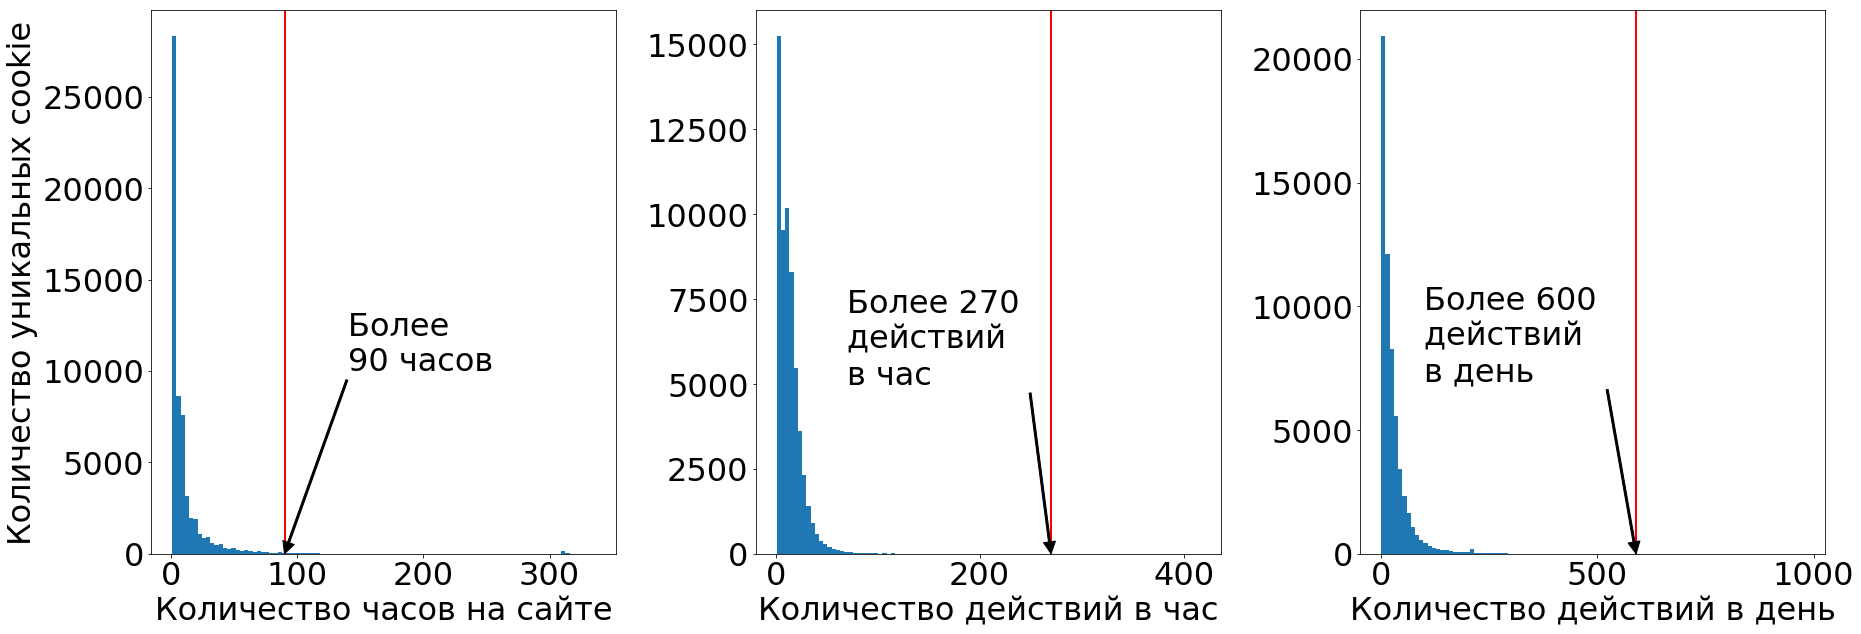

In [53]:
# Графики по величинам
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(30,10))
font = {'size'   : 32, 'family':'DejaVu Sans'}

matplotlib.rc('font', **font)


#plt.tight_layout()

#print ('Кол-во часов на сайте'), c_df2['cnt_hours'].mean()
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
#plt.title('Количество часов на сайте')
plt.xlabel('Количество часов на сайте')
plt.ylabel('Количество уникальных cookie')
plt.axvline(x=90,  linewidth=2, color='r')
plt.annotate('Более \n90 часов', xy=(90, 0), xytext=(140, 10000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )


plt.hist(c_df2[c_df2['cnt_hours'] >= 0]['cnt_hours'].values,bins=100)
#plt.show()

#plt.subplot(2,2,2)
#print ('Кол-во дней на сайте'), c_df2['cnt_dates'].mean()
#plt.title('Количество дней на сайте')
#plt.xlabel('Количество дней')
#plt.ylabel('Количество уникальных cookie')
#plt.hist(c_df2['cnt_dates'].values)
#plt.show()

plt.subplot(1,3,2)
plt.xlabel('Количество действий в час')
#plt.ylabel('Количество уникальных cookie')
#print ('Кол-во посещений в час'), c_df2['cnt_per_hour'].mean()
plt.axvline(x=270,  linewidth=2, color='r')
plt.annotate('Более 270 \nдействий \nв час', xy=(270, 0), xytext=(70, 5000),
            arrowprops=dict(facecolor='black', shrinkA=1, shrinkB=1, width=2),
            )
plt.hist(c_df2[c_df2['cnt_per_hour'] < 500]['cnt_per_hour'].values, bins = 100)
#plt.show()

plt.subplot(1,3,3)
plt.xlabel('Количество действий в день')
#plt.ylabel('Количество уникальных cookie')
#print ('Кол-во посещений в день на сайте'), c_df2['cnt_per_date'].mean()
plt.axvline(x=590,  linewidth=2, color='r')
plt.annotate('Более 600 \nдействий \nв день', xy=(590, 0), xytext=(100, 7000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.hist(c_df2[c_df2['cnt_per_date'] < 1000]['cnt_per_date'].values, bins = 100)

plt.savefig('shunia.png')

plt.show()

In [16]:
#Выкидываю тех у кого кол-во просмотров в день, час и кол-во часов больше среднее*20
x_bad_2 = c_df2[(c_df2['cnt_per_hour'] > c_df2['cnt_per_hour'].mean()*20) |\
      (c_df2['cnt_per_date'] > c_df2['cnt_per_date'].mean()*20) |\
      (c_df2['cnt_hours'] > c_df2['cnt_hours'].mean()*20)]['cookie'].drop_duplicates().values

In [52]:
len(sx_bad_2)

238

# соотношение view/search и search/view

In [17]:
#Выкидываю плохих с предыдущего шага
sx_bad_2 = set(x_bad_2)
df_4 = df_3[df_3['cookie'].apply(lambda x: x not in sx_bad_2)]

In [18]:
#Ко-во просмотров и поисков
r_df = df_4[(df_4['eventtype_group'] == 'Request_ItemSearch') | (df_4['eventtype_group'] == 'Request_ItemView')].\
    groupby(['cookie', 'eventtype_group']).size().reset_index().pivot('cookie', 'eventtype_group', 0).reset_index()

In [19]:
# Создаю новые переменные соотношение просмотров к поискам и наоборот
r_df['view_search'] = r_df['Request_ItemView']/r_df['Request_ItemSearch']
r_df['search_view'] = r_df['Request_ItemSearch']/r_df['Request_ItemView']

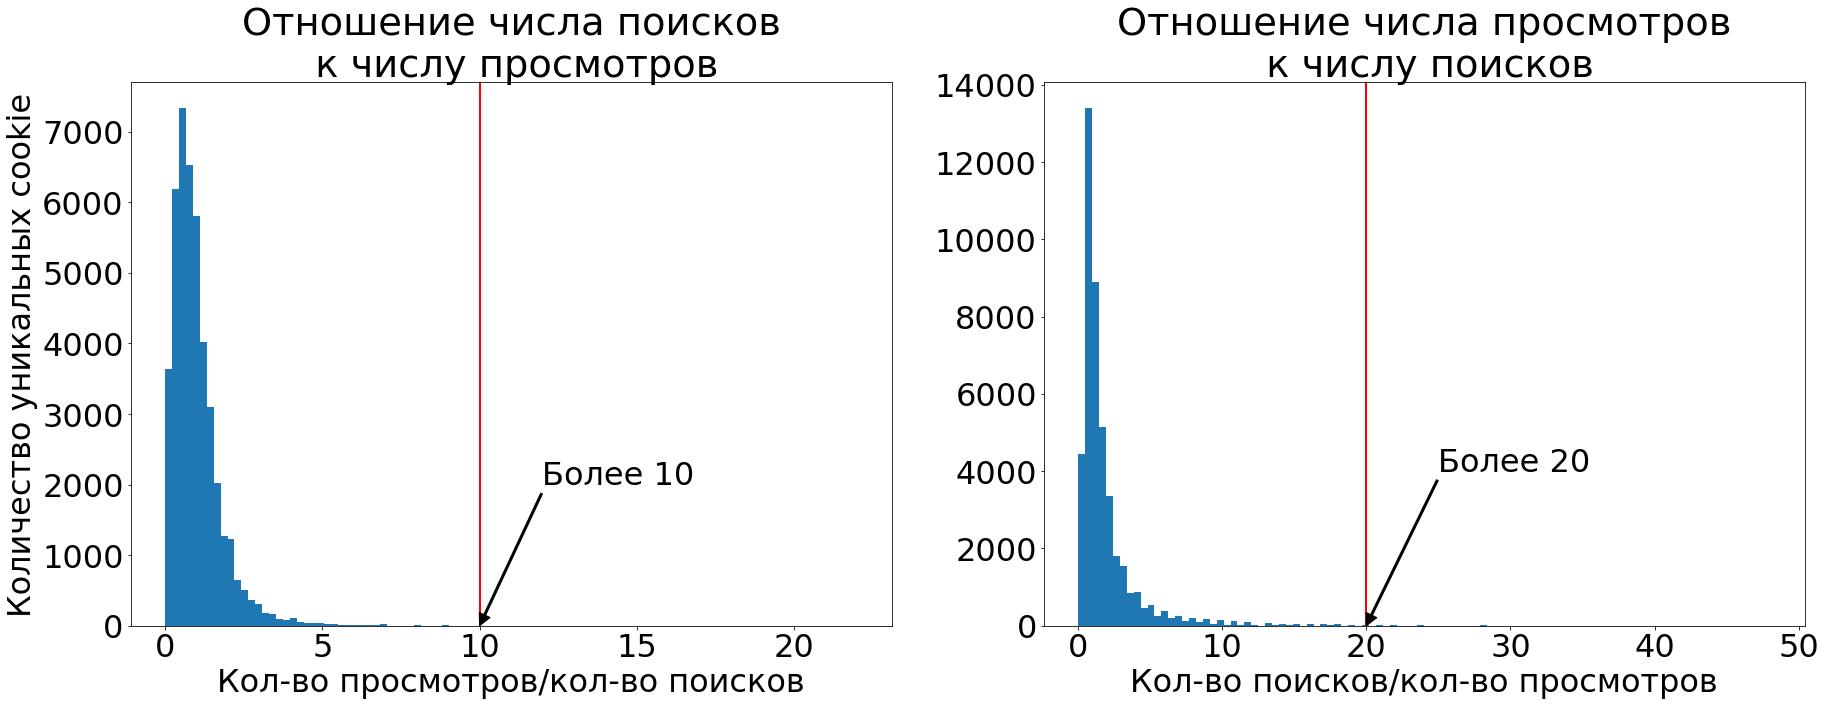

In [20]:
plt.figure(figsize=(30,10))
font = {'size'   : 32, 'family':'DejaVu Sans'}

matplotlib.rc('font', **font)

plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title('Отношение числа поисков\n к числу просмотров')
plt.xlabel('Кол-во просмотров/кол-во поисков')
plt.ylabel('Количество уникальных cookie')
plt.hist(r_df[r_df.view_search < 50]['view_search'].dropna().values, bins = 100)
plt.annotate('Более 10', xy=(10, 0), xytext=(12, 2000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.axvline(x=10,  linewidth=2, color='r')

plt.subplot(1,2,2)
plt.title('Отношение числа просмотров\n к числу поисков')
plt.xlabel('Кол-во поисков/кол-во просмотров')
plt.annotate('Более 20', xy=(20, 0), xytext=(25, 4000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.hist(r_df[r_df.search_view < 50]['search_view'].dropna().values, bins = 100)
plt.axvline(x=20,  linewidth=2, color='r')

plt.savefig('view_search.png')

plt.show()

In [21]:
# Отбираем в плохие те у кого отношения больше 20
x_bad_3 = r_df[(r_df.view_search > 10) | (r_df.search_view > 20)]['cookie'].drop_duplicates().values
sx_bad_3 = set(x_bad_3)

# Много на один ip

In [22]:
#Выкидываю плохих с предыдущего шага
df_5 = df_4[df_4['cookie'].apply(lambda x: x not in sx_bad_3)]

In [23]:
#сколько куки на 1 ip
i_df = df_5[['ip', 'cookie', 'ClientSideAppName']].drop_duplicates().groupby(['ip', 'ClientSideAppName']).size().\
rename('cnt').reset_index().pivot('ip', 'ClientSideAppName', 'cnt')

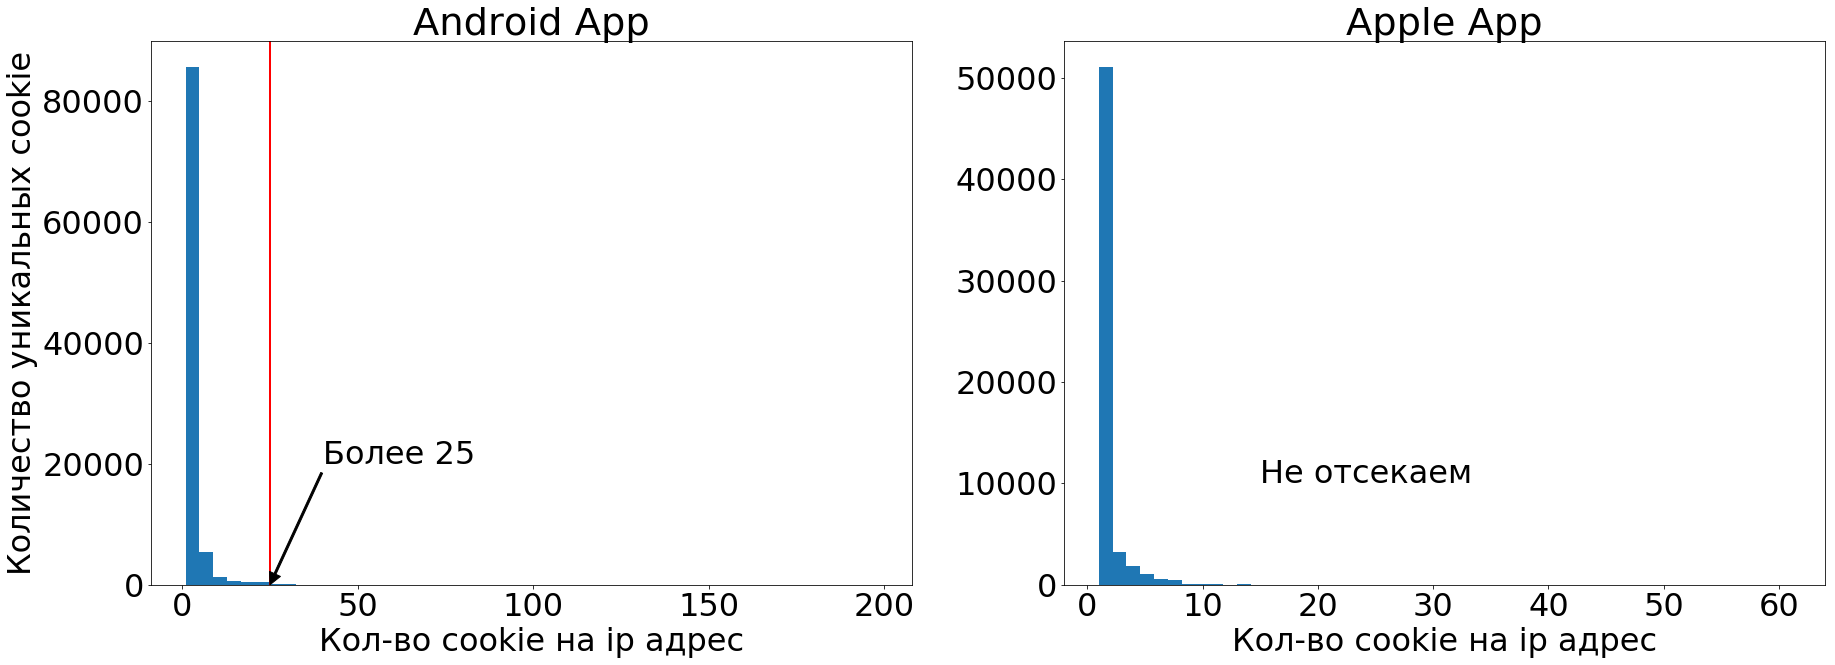

In [24]:
plt.figure(figsize=(30,10))
font = {'size'   : 32, 'family':'DejaVu Sans'}

matplotlib.rc('font', **font)

plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title('Android App')
plt.xlabel('Кол-во cookie на ip адрес')
plt.ylabel('Количество уникальных cookie')
plt.annotate('Более 25', xy=(25, 0), xytext=(40, 20000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.axvline(x=25,  linewidth=2, color='r')
plt.hist(i_df[i_df['Android App'] <200]['Android App'].dropna(), bins = 50)


plt.subplot(1,2,2)
plt.title('Apple App')
plt.xlabel('Кол-во cookie на ip адрес')
plt.annotate('Не отсекаем', xy=(0, 0), xytext=(15, 10000))
plt.hist(i_df['iPhone App'].dropna(), bins = 50)
plt.show()

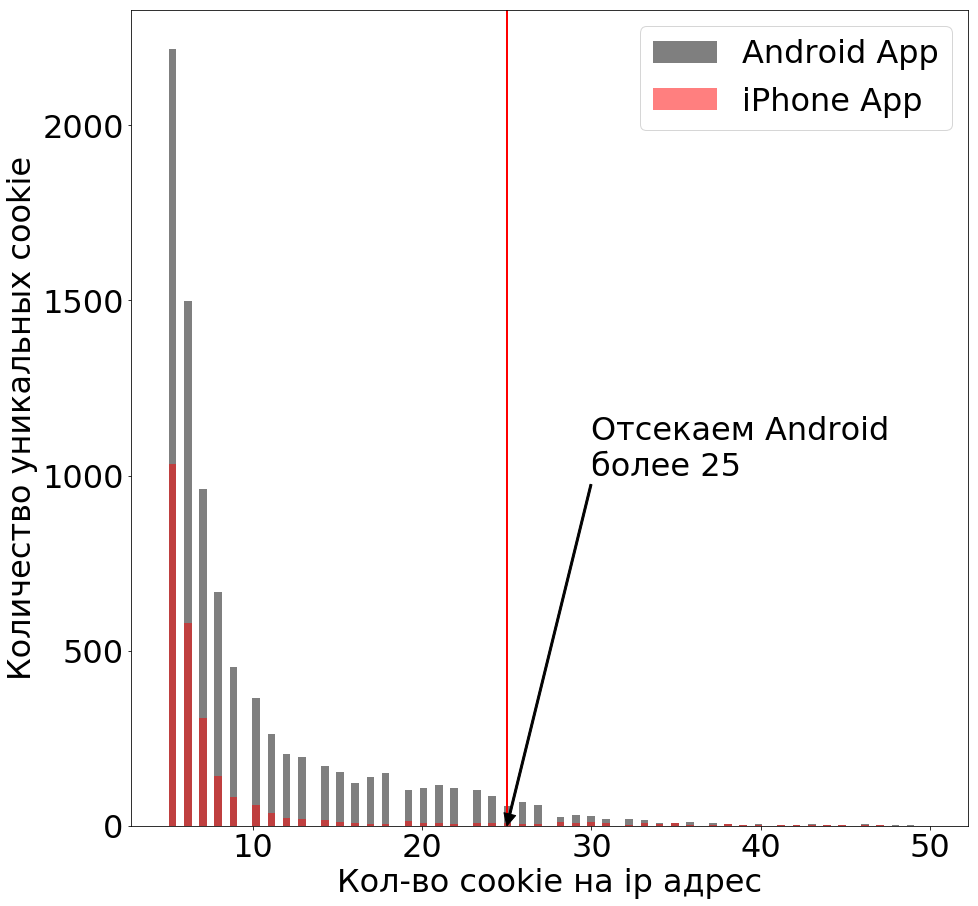

In [25]:
plt.figure(figsize=(15,15))
font = {'size'   : 32, 'family':'DejaVu Sans'}

matplotlib.rc('font', **font)

plt.subplots_adjust(wspace=0.2)

#plt.subplot(1,2,1)
#plt.title('Android App')
plt.xlabel('Кол-во cookie на ip адрес')
plt.ylabel('Количество уникальных cookie')
plt.annotate('Отсекаем Android \nболее 25', xy=(25, 0), xytext=(30, 1000),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.axvline(x=25,  linewidth=2, color='r')
plt.hist(i_df[(i_df['Android App'] <50) & (i_df['Android App'] >=5)]['Android App'].dropna(), bins = 100, range=(5,50),\
         label='Android App', alpha=0.5,color='k')

#plt.subplot(1,2,2)
#plt.title('Apple App')
plt.xlabel('Кол-во cookie на ip адрес')

plt.hist(i_df[(i_df['iPhone App'] <50) & (i_df['iPhone App'] >=5)]['iPhone App'], \
         bins = 100, label='iPhone App', alpha=0.5, color='r',range=(5,50))
plt.legend()
plt.savefig('ip.png')
plt.show()

In [26]:
# только андройд и больше 25 куки
bad_ip = i_df[(i_df['Android App'] > 25) & (i_df['iPhone App'].isnull())].\
    sort_values('Android App', ascending = False).reset_index()['ip'].values

In [27]:
s_bad_ip = set(bad_ip)
x_bad_4 = df_5[df_5.ip.apply(lambda x: x in s_bad_ip)]['cookie'].drop_duplicates().values

# По действиям - получилось выкидывать все просмотры и поиски

In [28]:
#Выкидываю плохих с предыдущего шага
sx_bad_4 = set(x_bad_4)
df_6 = df_5[df_5['cookie'].apply(lambda x: x not in sx_bad_4)]

In [29]:
# какие действия на каждое устройство
e_df = df_6[['cookie', 'ClientSideAppName', 'eventype_name']].drop_duplicates().\
    groupby(['cookie', 'ClientSideAppName'])\
    ['eventype_name'].apply(lambda x: ','.join(set(x))).reset_index().\
    groupby(['ClientSideAppName', 'eventype_name']).size().rename('cnt').reset_index().\
    pivot('eventype_name', 'ClientSideAppName', 'cnt').reset_index().fillna(0.5)

In [30]:
e_df['difference'] = e_df['Android App'].values/e_df['iPhone App'].values

In [31]:
e_df[e_df['Android App']>200][['eventype_name', 'Android App', 'iPhone App', 'difference']].\
                              sort_values('difference', ascending = False).to_latex('item_view.tex', index = False)

In [32]:
# В итоге удаляю все куки с которых были только item_search или item_view 
e_df1 = df_6.groupby(['cookie', 'ClientSideAppName'])['eventype_name'].apply(lambda x: ','.join(set(x))).reset_index()
s_bad_5 = e_df1[((e_df1['eventype_name'] == 'Item View') | (e_df1['eventype_name'] == 'Items Search')) \
                & (e_df1['ClientSideAppName'] == 'Android App')]['cookie'].\
                drop_duplicates().values

In [33]:
sx_bad_5 = set(s_bad_5)
good = set(df_6[df_6['cookie'].apply(lambda x: x not in sx_bad_5)]['cookie'])

In [34]:
#выгружаю для сабмита
res = df[['cookie', 'cookie_id']].drop_duplicates()
res['IsHuman']=df['cookie'].apply(lambda x: 1 if x in good else 0)
res.drop('cookie',axis=1).drop_duplicates().to_csv('submit2_s2.csv',index=False)

In [35]:
subm = res.drop('cookie',axis=1).drop_duplicates()

# Сверху forest, готовлю фичи

In [36]:
df_b=df.set_index('cookie_id').join(subm.set_index('cookie_id')).reset_index()
print (df_b.columns)

Index(['cookie_id', 'log_id', 'event_date', 'eventtype_id', 'eventtype_group',
       'eventype_name', 'is_event_pageview', 'ClientSideAppName', 'cookie',
       'user_id', 'category_id', 'ParentCategoryName', 'CategoryName',
       'location_id', 'useragent_id', 'useragent', 'ip', 'date', 'hour',
       'IsHuman'],
      dtype='object')


In [37]:
#опять дата время
df_b['date']=df_b['event_date'].apply(lambda x:x[:10])
df_b['hour']=df_b['event_date'].apply(lambda x:x[:13])

In [38]:
# считаю уникальное кол-во значений по каждой фиче на 1 куки_id
df_drp=df_b.fillna(-1).groupby('cookie_id')

tmp2=df[['cookie_id']].drop_duplicates().set_index('cookie_id')

for a in [u'eventtype_id',
       u'eventtype_group', u'eventype_name', u'is_event_pageview',
       u'ClientSideAppName', u'cookie', u'user_id', u'category_id',
       u'ParentCategoryName', u'CategoryName', u'location_id', u'useragent_id',
       u'useragent', u'ip','date','hour']:
    print (a)
    tmp2=tmp2.join(df_drp[a].apply(lambda x:len(set(x))).rename('un_'+a).reset_index().set_index('cookie_id'))
    

eventtype_id
eventtype_group
eventype_name
is_event_pageview
ClientSideAppName
cookie
user_id
category_id
ParentCategoryName
CategoryName
location_id
useragent_id
useragent
ip
date
hour


In [39]:
#Число действий
tmp2 = tmp2.join(df.groupby('cookie_id').size().rename('cnt').reset_index().set_index('cookie_id'))

In [40]:
# За день/за час
by_hour=df.groupby(['cookie_id','hour']).size().reset_index().groupby('cookie_id')
by_date=df.groupby(['cookie_id','date']).size().reset_index().groupby('cookie_id')

In [41]:
# Максимальное среднее кол-во действий за час или день
tmp2=tmp2.join(by_hour[0].max().rename('max_by_hour').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_hour[0].mean().rename('avg_by_hour').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_date[0].max().rename('max_by_date').reset_index().set_index('cookie_id'))
tmp2=tmp2.join(by_date[0].mean().rename('avg_by_date').reset_index().set_index('cookie_id'))

In [42]:
#переименование для dummy
def rename(a,x):
    try:
        return str(a)+'_'+str(x)
    except:
        return x

In [43]:
#категориальные в dummy
import datetime
tmp=[]

for a in [u'eventtype_id',  u'eventtype_group', u'eventype_name', u'is_event_pageview',
       u'ClientSideAppName', u'category_id',
       u'ParentCategoryName', u'CategoryName']:
    print (a, datetime.datetime.now())
    tmp3=pd.get_dummies(df[a])
    tmp3.columns=[rename(a,b) for b in tmp3.columns]
    tmp3=pd.concat([df[['cookie_id']],tmp3], axis=1)
    tmp.append(tmp3.groupby('cookie_id').sum())

eventtype_id 2017-02-20 21:56:51.128253
eventtype_group 2017-02-20 21:57:03.198142
eventype_name 2017-02-20 21:57:10.986747
is_event_pageview 2017-02-20 21:57:21.054021
ClientSideAppName 2017-02-20 21:57:22.660471
category_id 2017-02-20 21:57:24.791529
ParentCategoryName 2017-02-20 21:58:01.094861
CategoryName 2017-02-20 21:58:05.618208


In [44]:
tmp3=tmp[0]

for a in tmp[1:]:
    tmp3=tmp3.join(a)

In [45]:
#Вытаскиваю версию устройства
z=df[['cookie_id','useragent','ClientSideAppName']][df['useragent'].apply(lambda x:'AVITO' in str(x))].drop_duplicates()

z['version']=z.useragent.apply(lambda x:(str(x).split('(')[0].replace('AVITO ','').replace(' ','').replace(',','')))

z['version2']=z.useragent.\
apply(lambda x:(str(x).split('(')[0].replace('AVITO ','').replace(' ','').replace(',','').split('.')[0]))

In [46]:
def try_int(x):
    try:
        return int(x)
    except:
        return None

In [47]:
#из версий dummy
version=pd.get_dummies(z['version'])
version2=pd.get_dummies(z['version'])
v=pd.concat([z[['cookie_id']], version, version2],axis=1).groupby('cookie_id').sum()

In [48]:
#min и max версия для куки
max_v=z.groupby('cookie_id')['version2'].\
apply(lambda x:max([try_int(a) for a in x])).rename('min_verstion').reset_index().set_index('cookie_id')

min_v=z.groupby('cookie_id')['version2'].\
apply(lambda x:min([try_int(a) for a in x])).rename('max_verstion').reset_index().set_index('cookie_id')

tmp3=tmp3.join(v).join(max_v).join(min_v)

In [49]:
final_ds=tmp2.reset_index().set_index('cookie_id').join(tmp3)
final_ds=final_ds.join(df_b[['cookie_id','IsHuman']].drop_duplicates().set_index('cookie_id')).reset_index()
final_ds.to_pickle('finalds')

In [50]:
#разделяю выборку и сохраняю если потом буду использовать
X=final_ds.drop(['cookie_id','IsHuman'],axis=1).values
y=final_ds.IsHuman.values
ids=final_ds.cookie_id.values

import _pickle as pickle
f=open('q2.pk1','wb')
pickle.dump([X,y,ids],f,2)
f.close()

In [51]:
import _pickle as pickle
f=open('q2.pk1','rb')
X,y,ids=pickle.load(f)
f.close()

In [251]:
#для forest
# 1. Кросс-валидация
from sklearn.cross_validation import KFold
cv = KFold(len(y),n_folds=5, shuffle=True, random_state=0)

/Users/shunia/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [252]:
#параметры дерева
import numpy as np
pred=np.zeros(len(y))

from sklearn.ensemble import ExtraTreesClassifier
et=ExtraTreesClassifier(n_estimators=300, n_jobs=-1,min_samples_split=100)

In [253]:
#На 4 частях обучаемся 1 предсказываем
import datetime
# я повторяю эту итерацию 2 раза с разным разбиением
#cv = KFold(len(y),n_folds=6, shuffle=True, random_state=3) 
X[np.isnan(X)]=0
for a,b in cv:
    print (datetime.datetime.now())
    et.fit(X[a],y[a])
    pred[b]=et.predict_proba(X[b])[:,1]

2017-02-19 23:55:33.200696
2017-02-20 00:02:32.374506
2017-02-20 00:09:28.783660
2017-02-20 00:16:31.328101
2017-02-20 00:22:57.873302


In [254]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, pred)

0.99995948137106094

In [255]:
df=pd.DataFrame(np.concatenate([y.reshape(438657,1), pred.reshape(438657,1)],axis=1),columns=['y','pred'])
df['cookie_id']=ids

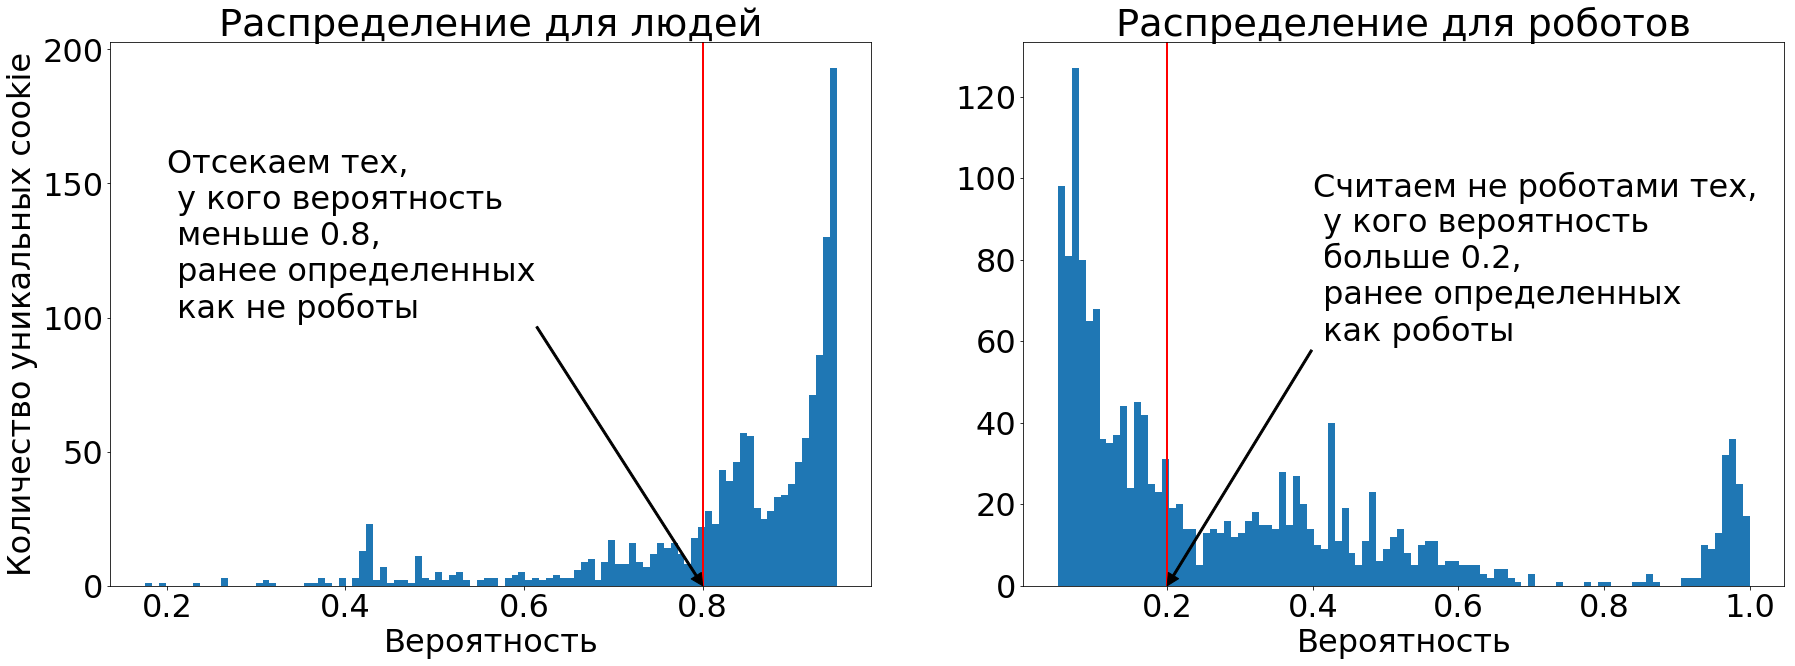

In [288]:
plt.figure(figsize=(30,10))
font = {'size'   : 32, 'family':'DejaVu Sans'}

matplotlib.rc('font', **font)

plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title('Распределение для людей')
plt.xlabel('Вероятность')
plt.ylabel('Количество уникальных cookie')
plt.annotate('Отсекаем тех,\n у кого вероятность\n меньше 0.8,\n ранее определенных\n как не роботы', xy=(0.8, 0), xytext=(0.2, 100),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.axvline(x=0.8,  linewidth=2, color='r')
plt.hist(df[(df['y']==1) & (df['pred']<0.95)]['pred'].values, bins=100)


plt.subplot(1,2,2)
plt.title('Распределение для роботов')
plt.xlabel('Вероятность')
plt.annotate('Считаем не роботами тех,\n у кого вероятность\n больше 0.2,\n ранее определенных\n как роботы', xy=(0.2, 0), xytext=(0.4, 60),
            arrowprops=dict(facecolor='black', shrink=0.00, width=2),
            )
plt.axvline(x=0.2,  linewidth=2, color='r')
plt.hist(df[(df['y']==0) & (df['pred']>0.05)]['pred'].values, bins=100)
plt.savefig('forest.png')
plt.show()


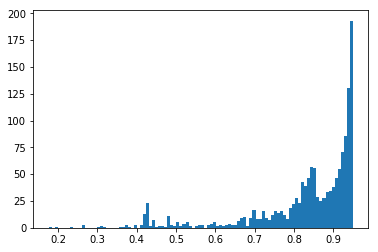

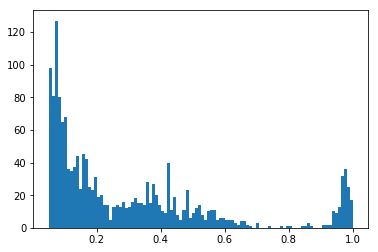

In [260]:
#Распределение верояьностей для 0 и 1
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df[(df['y']==1) & (df['pred']<0.95)]['pred'].values, bins=100)
plt.show()

plt.hist(df[(df['y']==0) & (df['pred']>0.05)]['pred'].values, bins=100)
plt.show()

In [131]:
# Если вероятность меньше 0,8 а у нас промечен как человек - убираем, если у нас промечен как робот, 
#а вероятность больше 0.2
df['IsHuman']=df[['y','pred']].apply(lambda x: 0 if (x[0]==0 and x[1]<0.2) or (x[0]==1 and x[1]<0.8) else 1,axis=1)
df[['cookie_id','IsHuman']].to_csv('test_v3.csv',index=False)